In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [2]:
###### Espace latent 2 dimensions

latent_dims = 64
num_epochs = 500
batch_size = 25
capacity = 2
learning_rate = 5e-4

# Chargement des données 


In [3]:
import os
import descriptors
import numpy as np

dict_r1 = np.load('data_dict.npy', allow_pickle=True).item()

train_db1 = np.zeros([len(dict_r1['env']),2,750])


i = 0
for sample in dict_r1['env']:
    train_db1[i,:,:] = sample
    i+=1

dict_r2 = np.load('data_dict_jerem_v1.npy', allow_pickle=True).item()

train_db2 = np.zeros([len(dict_r2['env']),2,750])


i = 0
for sample in dict_r2['env']:
    train_db2[i,:,:] = sample
    i+=1
#
 
#train_db = np.concatenate((train_db1, train_db2)) 
train_db = train_db1
train_db[:,1,:] = np.log10(train_db[:,1,:])

MAX1 = np.max(train_db[:,0,:])
MAX2 = np.max(train_db[:,1,:])
train_db[:,0,:] /= MAX1
train_db[:,1,:] /= MAX2
train_dataset =  torch.utils.data.TensorDataset(torch.from_numpy(train_db))

print(train_db.shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)

test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)

(252, 2, 750)


# Defintion du AE 

Kernel Size = 4 papier qui explique pourquoi: https://distill.pub/2016/deconv-checkerboard/

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity     
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=c, kernel_size=10, stride=2, padding=2), nn.BatchNorm1d(c)) # out: c, 372
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c*4, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*8, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(8*c)) # out: c*2, 186
        self.conv5 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(8*c)) # out: c*2, 186
        self.lin1 = nn.Linear(8*c*47, latent_dims*8)
        self.lin2 = nn.Linear(latent_dims*8, latent_dims*4)
        self.lin3 = nn.Linear(latent_dims*4, latent_dims)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.lin1 = nn.Linear(latent_dims, latent_dims*4)
        self.lin2 = nn.Linear(latent_dims*4, latent_dims*8)
        self.lin3 = nn.Linear(latent_dims*8, 8*c*47)
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(8*c))
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*4, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*2, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(c)) # out: c*2, 186
        self.conv5 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=2, kernel_size=10, stride=1, padding=4)) # out: c, 372
        self.upsample1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.upsamplef = nn.Upsample(size=751, mode="nearest")

            
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = x.view(x.size(0), capacity*8, 47) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv1(x))
        x = self.upsample1(x)
        x = F.relu(self.conv2(x))
        x = self.upsample1(x)
        x = F.relu(self.conv3(x))
        x = self.upsample1(x)
        x = F.relu(self.conv4(x))
        x = self.upsamplef(x)
        x = F.relu(self.conv5(x))
        x = torch.sigmoid(x) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
        
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x_recon = self.decoder(x)
        return x_recon
    
def ae_loss(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
    return recon_loss
    
ae = Autoencoder()

num_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1071862


# Entrainement

In [5]:
optimizer = torch.optim.Adam(params=ae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
ae.train()

train_loss_avg = []
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch in train_loader:

        #image_batch = image_batch.to(device)
        image_batch = torch.DoubleTensor(image_batch[0])
        image_batch = image_batch.view(batch_size,2,750)

        
        # vae reconstruction
        image_batch_recon = ae(image_batch.float())
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch.float())
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()

        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    
    if epoch%20 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 500] average reconstruction error: 0.077718
Epoch [21 / 500] average reconstruction error: 0.011708
Epoch [41 / 500] average reconstruction error: 0.003999
Epoch [61 / 500] average reconstruction error: 0.003310
Epoch [81 / 500] average reconstruction error: 0.003248
Epoch [101 / 500] average reconstruction error: 0.003132
Epoch [121 / 500] average reconstruction error: 0.003088
Epoch [141 / 500] average reconstruction error: 0.002965
Epoch [161 / 500] average reconstruction error: 0.002991
Epoch [181 / 500] average reconstruction error: 0.002871
Epoch [201 / 500] average reconstruction error: 0.002830
Epoch [221 / 500] average reconstruction error: 0.002878
Epoch [241 / 500] average reconstruction error: 0.002770
Epoch [261 / 500] average reconstruction error: 0.002763
Epoch [281 / 500] average reconstruction error: 0.002754
Epoch [301 / 500] average reconstruction error: 0.002536
Epoch [321 / 500] average reconstruction error: 0.002461
Epoch [341 / 500] averag

# Affichage de la courbe de loss 

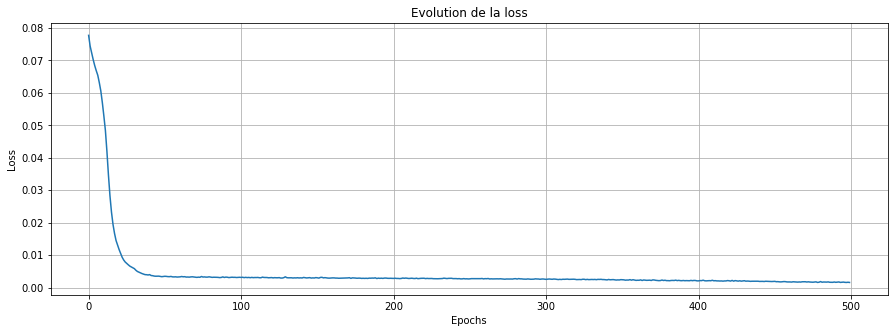

In [8]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15,5))
plt.subplot(111)
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution de la loss')
plt.grid()
plt.show()

# Reconstruction 

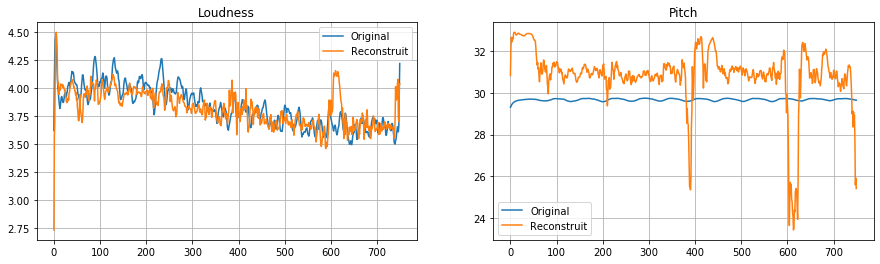

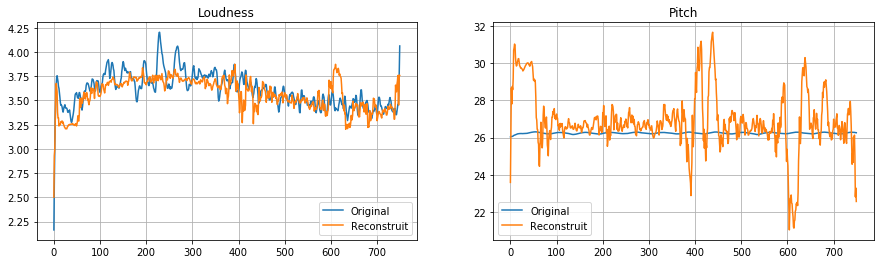

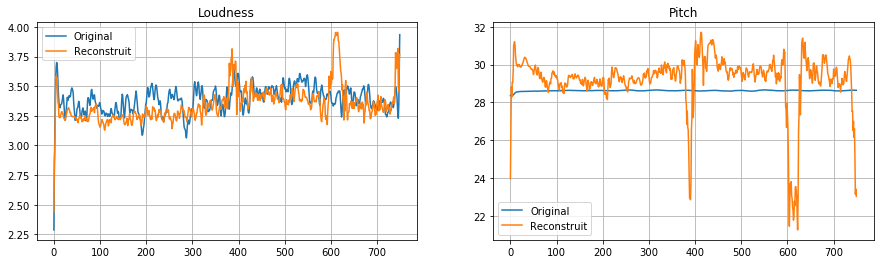

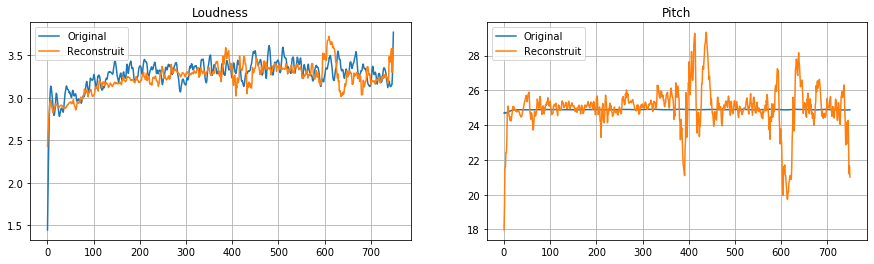

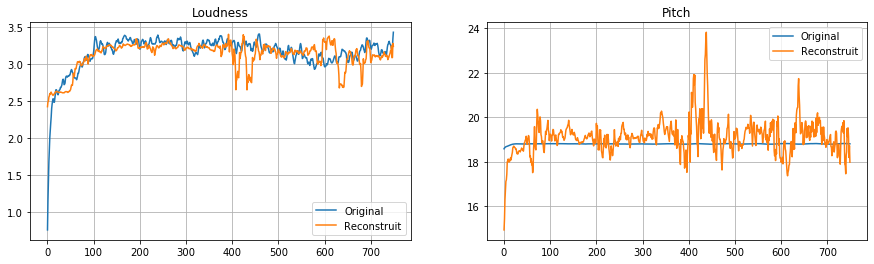

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

ae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction

for i in [10,20,30,40,50]:
    images = train_db[i,:,:]
    # Affichage de l'image originale

    plt.figure(i,figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot((images[0,:])*MAX1, label='Original')
    plt.title('Loudness')
    plt.subplot(1,2,2)
    plt.plot(np.power(10,images[1,:])*MAX2, label='Original')  
    plt.title('Pitch')
  
    # Reconstruct and visualise the images using the vae
    images_recon = ae(torch.from_numpy(images).view(1,2,750).float())
    images_recon = images_recon.detach().numpy()
    plt.figure(i,figsize=(15,4))
    plt.subplot(1,2,1)
    plt.grid()
    plt.plot(images_recon[0,0,:]*MAX1, label='Reconstruit')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(np.power(10,images_recon[0,1,:])*MAX2, label='Reconstruit')
    plt.grid()
    plt.legend()
    plt.show()


### DDSP pour écouter résultats

In [18]:
#DDSP sur la reconstruction
pitch = torch.from_numpy(np.power(10,images_recon[0,1,:])*MAX2).float().reshape(1, -1, 1)
loudness = torch.from_numpy(images_recon[0,0,:]*MAX1).float().reshape(1, -1, 1)

ddsp = torch.jit.load('ddsp_solordinario_pretrained.ts')

reconstruction_out = ddsp(pitch, loudness)

In [14]:
#DDSP sur l'original Original
pitch = torch.from_numpy(images[1,:]*MAX2).float().reshape(1, -1, 1)
loudness = torch.from_numpy(images[0,:]*MAX1).float().reshape(1, -1, 1)

ddsp = torch.jit.load('ddsp_solordinario_pretrained.ts')

reconstruction_in = ddsp(pitch, loudness)

In [19]:
#Ecouter les sons
import sounddevice as sd
sig = reconstruction_out[0,:,0]
sig = sig.detach().numpy()
sd.play(sig*0.5/np.max(sig), 16000)
